In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
# from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = [ 'Bridge-Pose',' Child-Pose',' Cobra-Pose',' Downward-Dog-Pose',' Pigeon-Pose',' Standing-Mountain-Pose',' Tree-Pose',' Triangle-Pose',' Warrior-Pose']

set_seeds()
pretrained_vit.heads =nn.Sequential(nn.Linear(in_features=768,out_features=512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(in_features=512,out_features=len(class_names))).to(device)

# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

F:\anaconda\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 9]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
# Setup directory paths to train and test images
train_dir=r'F:\ML_Projects\Image_Classification\mohan1\train'
test_dir =  r'F:\ML_Projects\Image_Classification\mohan1\test'
import numpy as np

In [6]:
# import os

# def get_folder_names(folder_path):
#     # Get all names inside the folder
#     names = os.listdir(folder_path)
    
#     # Filter out directories
#     folder_names = [name for name in names if os.path.isdir(os.path.join(folder_path, name))]
    
#     return "',' ".join(folder_names)

# # Example usage
# folder_path =r'F:\ML_Projects\Image_Classification\mohan1\train'
# folder_names = get_folder_names(folder_path)
# print("Folder names inside", folder_path, ":", folder_names)



In [7]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()

print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
    
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=64) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)                                                                                            batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [10]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import precision_score, recall_score, f1_score

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               lr_scheduler: torch.optim.lr_scheduler = None) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float, float, float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss, testing accuracy, precision, recall, and F1-score metrics.
    In the form (test_loss, test_accuracy, precision, recall, f1_score). For example:

    (0.0223, 0.8985, 0.8621, 0.9254, 0.8923)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Lists to store true and predicted labels for computing precision, recall, and F1-score
    true_labels = []
    pred_labels = []

    # Turn off gradient computation
    with torch.no_grad():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            # Store true and predicted labels
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(test_pred_labels.cpu().numpy())

    # Compute precision, recall, and F1-score
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc, precision, recall, f1

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          lr_scheduler: torch.optim.lr_scheduler = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "precision": [],
               "recall": [],
               "f1_score": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc, precision, recall, f1 = test_step(model=model,
                                                               dataloader=test_dataloader,
                                                               loss_fn=loss_fn,
                                                               device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"precision: {precision:.4f} | "
          f"recall: {recall:.4f} | "
          f"f1_score: {f1:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1_score"].append(f1)

    # Return the filled results at the end of the epochs
    return results


In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
learning_rate = 0.001

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device,
                                      lr_scheduler=scheduler 
                               
                                    
                             )


E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5481 | train_acc: 0.4975 | test_loss: 0.9608 | test_acc: 0.7412 | precision: 0.7562 | recall: 0.7386 | f1_score: 0.7345
Epoch: 2 | train_loss: 0.8039 | train_acc: 0.7539 | test_loss: 0.7759 | test_acc: 0.7718 | precision: 0.7766 | recall: 0.7675 | f1_score: 0.7673
Epoch: 3 | train_loss: 0.6247 | train_acc: 0.8215 | test_loss: 0.6484 | test_acc: 0.8273 | precision: 0.8211 | recall: 0.8191 | f1_score: 0.8181
Epoch: 4 | train_loss: 0.4794 | train_acc: 0.8723 | test_loss: 0.6091 | test_acc: 0.8273 | precision: 0.8203 | recall: 0.8191 | f1_score: 0.8185
Epoch: 5 | train_loss: 0.4111 | train_acc: 0.8854 | test_loss: 0.5740 | test_acc: 0.8251 | precision: 0.8254 | recall: 0.8207 | f1_score: 0.8199
Epoch: 6 | train_loss: 0.3506 | train_acc: 0.9077 | test_loss: 0.5634 | test_acc: 0.8381 | precision: 0.8270 | recall: 0.8267 | f1_score: 0.8248
Epoch: 7 | train_loss: 0.2857 | train_acc: 0.9212 | test_loss: 0.5434 | test_acc: 0.8444 | precision: 0.8384 | recall: 0.8374 | f1

In [12]:
print(pretrained_vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [13]:
# # Plot the loss curves
# from helper_functions import plot_loss_curves

# plot_loss_curves(pretrained_vit_results) 

In [14]:
import torch
model=pretrained_vit
# Assuming `model` is your PyTorch model
torch.save(model.state_dict(), 'model_ViT2.pth')

In [11]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, models, transforms
# from torch.utils.data import DataLoader, random_split
# from torch.utils.tensorboard import SummaryWriter
# from torch.optim.lr_scheduler import StepLR

# class ResNet50Model(nn.Module):
#     def __init__(self, num_classes, dropout_rate):
#         super(ResNet50Model, self).__init__()
#         self.base_model = models.resnet50(pretrained=True)
#         for param in self.base_model.parameters():
#             param.requires_grad = False
#         num_ftrs = self.base_model.fc.in_features
#         self.base_model.fc = nn.Sequential(
#             nn.Dropout(dropout_rate),
#             nn.Linear(num_ftrs, num_classes)
#         )

#     def forward(self, x):
#         return self.base_model(x)

# # Hyperparameters grid
# learning_rates = [1e-4, 1e-3, 1e-2]
# batch_sizes = [32, 64]
# dropout_rates = [0.4]
# num_classes = 9

# # Data augmentation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# # # Setup directory paths to train and test images
# # train_dir=r'F:\ML_Projects\Image_Classification\mohan1\train'
# # test_dir =  r'F:\ML_Projects\Image_Classification\mohan1\test'
# # import numpy as np

# # Assuming datasets are already prepared
# train_dataset = datasets.ImageFolder(r'F:\ML_Projects\Image_Classification\mohan1\train', transform=data_transforms['train'])
# val_dataset = datasets.ImageFolder(r'F:\ML_Projects\Image_Classification\mohan1\test', transform=data_transforms['val'])

# # Grid search
# best_acc = 0.0
# best_params = {}

# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         for dropout_rate in dropout_rates:
#             # Split the data
#             train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#             val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#             # Initialize the model, criterion, optimizer, and scheduler
#             model = ResNet50Model(num_classes, dropout_rate)
#             criterion = nn.CrossEntropyLoss()
#             optimizer = optim.Adam(model.parameters(), lr=lr)
#             scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

#             # Training loop
#             num_epochs = 5  # Adjust as needed for your specific case
#             for epoch in range(num_epochs):
#                 model.train()
#                 running_loss = 0.0
#                 running_corrects = 0
#                 for inputs, labels in train_loader:
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)

#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                     running_loss += loss.item() * inputs.size(0)
#                     _, preds = torch.max(outputs, 1)
#                     running_corrects += torch.sum(preds == labels.data)

#                 epoch_loss = running_loss / len(train_loader.dataset)
#                 epoch_acc = running_corrects.double() / len(train_loader.dataset)

#                 # Validation phase
#                 model.eval()
#                 val_loss = 0.0
#                 val_corrects = 0
#                 with torch.no_grad():
#                     for inputs, labels in val_loader:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)
#                         val_loss += loss.item() * inputs.size(0)
#                         _, preds = torch.max(outputs, 1)
#                         val_corrects += torch.sum(preds == labels.data)

#                 val_loss = val_loss / len(val_loader.dataset)
#                 val_acc = val_corrects.double() / len(val_loader.dataset)

#                 print(f'LR: {lr}, Batch Size: {batch_size}, Dropout: {dropout_rate}, Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

#                 # Step the scheduler
#                 scheduler.step()

#                 # Update best parameters
#                 if val_acc > best_acc:
#                     best_acc = val_acc
#                     best_params = {'learning_rate': lr, 'batch_size': batch_size, 'dropout_rate': dropout_rate}

# print(f'Best Accuracy: {best_acc:.4f} with params: {best_params}')
# # Best Accuracy: 0.6581 with params: {'learning_rate': 0.01, 'batch_size': 64, 'dropout_rate': 0.3}


ModuleNotFoundError: No module named 'tensorboard'

In [13]:
img_height, img_width = 224,224
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

In [14]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
    
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [15]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                                     transform=transform,
                                                                                                     batch_size=64,num_workers=0) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)                                                                                            batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the ResNet50 model
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        # Load the pre-trained ResNet50 model
        self.base_model = models.resnet50(pretrained=True)
        # Freeze the layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Modify the classifier
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(0.4),
            nn.Sigmoid()
        )



    def forward(self, x):
        # Forward pass through the base model
        x = self.base_model(x)
        return x

# Instantiate the model
num_classes = 9  # Change this based on your task
model = ResNet50Model(num_classes)

# Print the model architecture
print(model)



F:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50Model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score



# Assuming train_dataloader, test_dataloader, and num_classes are defined

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)


# Sample training loop
num_epochs = 30 # Define number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


In [12]:
import torch

# Assuming `model` is your PyTorch model
torch.save(model.state_dict(), 'model3_resnet2.pth')

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


In [7]:
img_height, img_width = 224,224
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
    
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                                     transform=transform,
                                                                                                     batch_size=64,num_workers=0) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)                                                                                            batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [12]:
# //current
train_loader, test_loader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                                     transform=transform,
                                                                                                     batch_size=64,num_workers=0) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)                                                                                            batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch 1/5.. Train loss: 1.185.. Test loss: 0.739.. Test accuracy: 0.798.. Test precision: 0.807.. Test recall: 0.798.. Test F1: 0.796


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch 2/5.. Train loss: 0.351.. Test loss: 0.522.. Test accuracy: 0.833.. Test precision: 0.850.. Test recall: 0.833.. Test F1: 0.834


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch 3/5.. Train loss: 0.185.. Test loss: 0.621.. Test accuracy: 0.837.. Test precision: 0.846.. Test recall: 0.837.. Test F1: 0.837


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch 4/5.. Train loss: 0.139.. Test loss: 0.495.. Test accuracy: 0.869.. Test precision: 0.874.. Test recall: 0.869.. Test F1: 0.870


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch 5/5.. Train loss: 0.104.. Test loss: 0.559.. Test accuracy: 0.872.. Test precision: 0.873.. Test recall: 0.872.. Test F1: 0.872


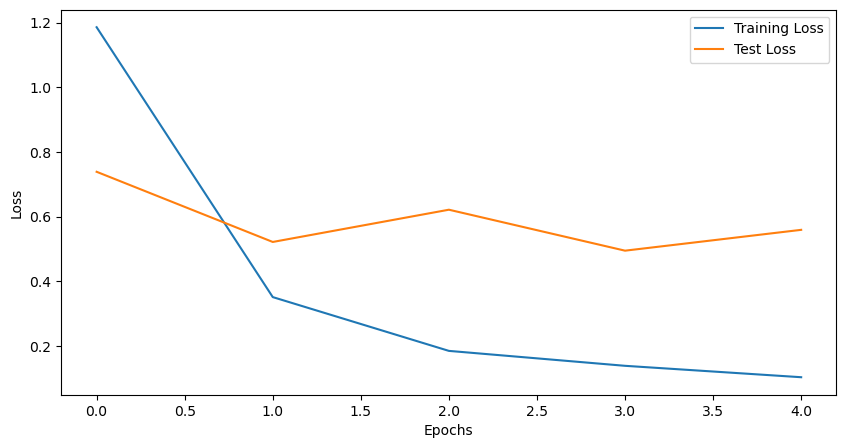

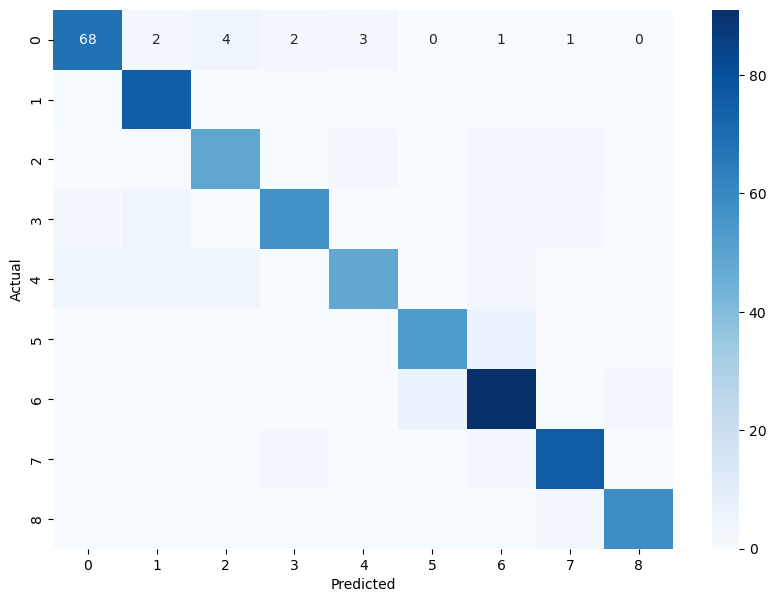

Final Test Accuracy: 0.872
Final Test Precision: 0.873
Final Test Recall: 0.872
Final Test F1 Score: 0.872


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the necessary datasets are available as `train_loader` and `test_loader`
# train_loader = ...
# test_loader = ...

# Define the DenseNet201 model with updated classifier and unfreezing some layers
class DenseNet201Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201Model, self).__init__()
        self.base_model = models.densenet201(pretrained=True)
        for name, param in self.base_model.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1920, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Instantiate the model
num_classes = 9
model = DenseNet201Model(num_classes).cuda()  # Assuming a GPU is available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

# Training and Evaluation function
def train_and_evaluate(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=5):
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        scheduler.step(test_loss)

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}.. '
              f'Train loss: {train_loss:.3f}.. '
              f'Test loss: {test_loss:.3f}.. '
              f'Test accuracy: {accuracy:.3f}.. '
              f'Test precision: {precision:.3f}.. '
              f'Test recall: {recall:.3f}.. '
              f'Test F1: {f1:.3f}')

    return train_losses, test_losses, accuracy_list, precision_list, recall_list, f1_list, all_labels, all_preds

# Define data loaders (sample code, replace with actual data loading logic)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# # Placeholder for actual dataset paths
# train_dataset = datasets.ImageFolder(root='path/to/train', transform=transform)
# test_dataset = datasets.ImageFolder(root='path/to/test', transform=transform)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train and evaluate the model
train_losses, test_losses, accuracy_list, precision_list, recall_list, f1_list, all_labels, all_preds = train_and_evaluate(
    model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=5
)

# Plot training and test loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print final metrics
print(f"Final Test Accuracy: {accuracy_list[-1]:.3f}")
print(f"Final Test Precision: {precision_list[-1]:.3f}")
print(f"Final Test Recall: {recall_list[-1]:.3f}")
print(f"Final Test F1 Score: {f1_list[-1]:.3f}")


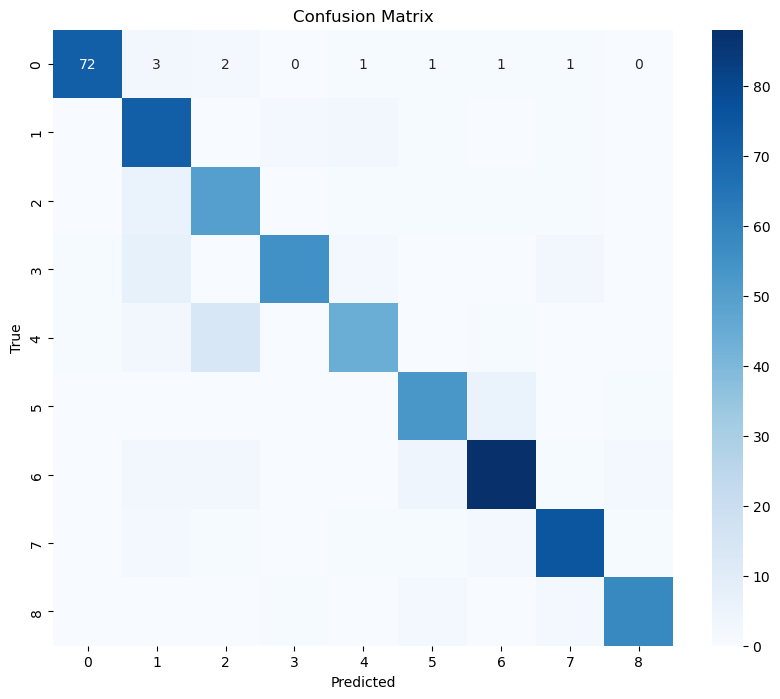

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the DenseNet201 model with updated classifier and unfreezing some layers
class DenseNet201Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201Model, self).__init__()
        self.base_model = models.densenet201(pretrained=True)
        for name, param in self.base_model.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1920, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Instantiate the model
num_classes = 9
model = DenseNet201Model(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Sample training loop
num_epochs = 25


# Collect training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    scheduler.step(avg_val_loss)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

    


F:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'train_dataloader' is not defined

CURRENT

Epoch [1/5], Train Loss: 1.1439802820483844, Test Loss: 0.8481466228311713, Test Accuracy: 0.7522796352583586, Precision: 0.7782107487412064, Recall: 0.7522796352583586, F1 Score: 0.7540759856148648


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [2/5], Train Loss: 0.38570837179819745, Test Loss: 0.5371975952928717, Test Accuracy: 0.8267477203647416, Precision: 0.8370198352804051, Recall: 0.8267477203647416, F1 Score: 0.8263456230259152


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [3/5], Train Loss: 0.21204440155997872, Test Loss: 0.6688820828091014, Test Accuracy: 0.8404255319148937, Precision: 0.8515300047422288, Recall: 0.8404255319148937, F1 Score: 0.8423609259469139


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [4/5], Train Loss: 0.14818674993390837, Test Loss: 0.5055507584051653, Test Accuracy: 0.8677811550151976, Precision: 0.8783495949267092, Recall: 0.8677811550151976, F1 Score: 0.8695979879968353


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [5/5], Train Loss: 0.08999418397434056, Test Loss: 0.5418642705137079, Test Accuracy: 0.8693009118541033, Precision: 0.874988818052782, Recall: 0.8693009118541033, F1 Score: 0.870264508216781


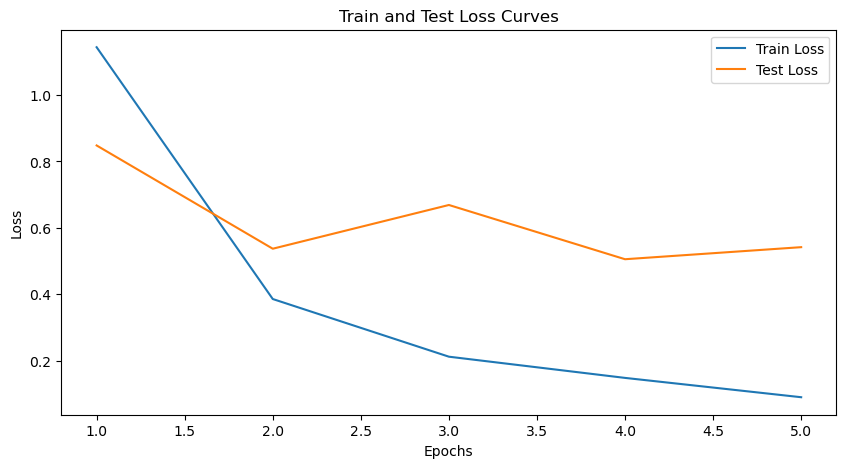

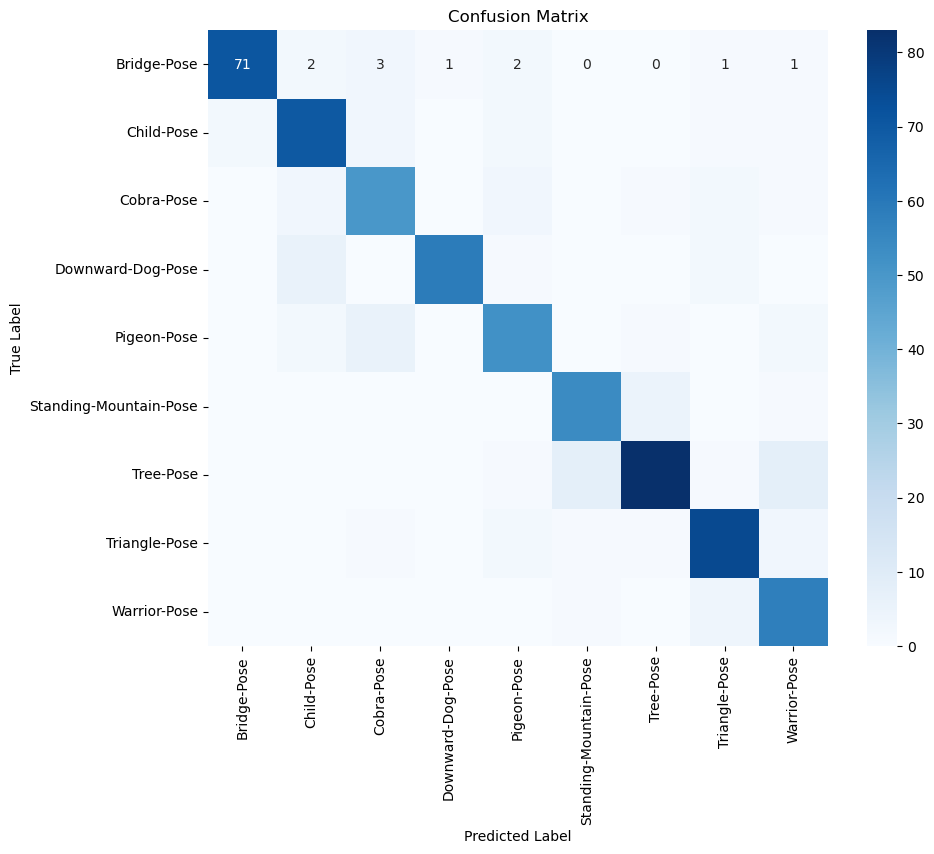

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the DenseNet201 model with updated classifier and unfreezing some layers
class DenseNet201Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201Model, self).__init__()
        self.base_model = models.densenet201(pretrained=True)
        for name, param in self.base_model.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1920, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Instantiate the model
num_classes = 9
model = DenseNet201Model(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Sample training loop
num_epochs = 5
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # use only the primary output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # use only the primary output
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    test_losses.append(test_loss / len(test_dataloader))

    accuracy = correct / total
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

scheduler.step(avg_val_loss)
# Plotting train and test loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Curves')
plt.legend()
plt.show()

# Plotting confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [1/25], Train Loss: 1.1629, Val Loss: 0.7516, Accuracy: 0.8040, Precision: 0.8207, Recall: 0.7922, F1 Score: 0.7983


F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/25], Train Loss: 0.3690, Val Loss: 0.5483, Accuracy: 0.8450, Precision: 0.8538, Recall: 0.8379, F1 Score: 0.8399


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [3/25], Train Loss: 0.2057, Val Loss: 0.4711, Accuracy: 0.8693, Precision: 0.8781, Recall: 0.8632, F1 Score: 0.8675


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [4/25], Train Loss: 0.1098, Val Loss: 0.5044, Accuracy: 0.8739, Precision: 0.8761, Recall: 0.8716, F1 Score: 0.8717


F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/25], Train Loss: 0.1084, Val Loss: 0.6637, Accuracy: 0.8587, Precision: 0.8700, Recall: 0.8556, F1 Score: 0.8587


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [6/25], Train Loss: 0.0795, Val Loss: 0.5031, Accuracy: 0.8769, Precision: 0.8787, Recall: 0.8734, F1 Score: 0.8755


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [7/25], Train Loss: 0.0767, Val Loss: 0.5551, Accuracy: 0.8708, Precision: 0.8725, Recall: 0.8662, F1 Score: 0.8679


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [8/25], Train Loss: 0.0630, Val Loss: 0.5263, Accuracy: 0.8875, Precision: 0.8900, Recall: 0.8854, F1 Score: 0.8867


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [9/25], Train Loss: 0.0615, Val Loss: 0.6104, Accuracy: 0.8784, Precision: 0.8862, Recall: 0.8751, F1 Score: 0.8787


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [10/25], Train Loss: 0.0595, Val Loss: 0.5424, Accuracy: 0.8815, Precision: 0.8867, Recall: 0.8770, F1 Score: 0.8805


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [11/25], Train Loss: 0.0486, Val Loss: 0.5293, Accuracy: 0.8875, Precision: 0.8902, Recall: 0.8841, F1 Score: 0.8863


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [12/25], Train Loss: 0.0474, Val Loss: 0.5304, Accuracy: 0.8891, Precision: 0.8912, Recall: 0.8873, F1 Score: 0.8885


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [13/25], Train Loss: 0.0474, Val Loss: 0.5318, Accuracy: 0.8891, Precision: 0.8910, Recall: 0.8866, F1 Score: 0.8880


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [14/25], Train Loss: 0.0493, Val Loss: 0.5346, Accuracy: 0.8906, Precision: 0.8925, Recall: 0.8891, F1 Score: 0.8900


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [15/25], Train Loss: 0.0434, Val Loss: 0.5417, Accuracy: 0.8891, Precision: 0.8906, Recall: 0.8870, F1 Score: 0.8880


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [16/25], Train Loss: 0.0432, Val Loss: 0.5408, Accuracy: 0.8891, Precision: 0.8891, Recall: 0.8873, F1 Score: 0.8877


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [17/25], Train Loss: 0.0411, Val Loss: 0.5400, Accuracy: 0.8906, Precision: 0.8915, Recall: 0.8891, F1 Score: 0.8896


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [18/25], Train Loss: 0.0417, Val Loss: 0.5420, Accuracy: 0.8875, Precision: 0.8868, Recall: 0.8855, F1 Score: 0.8859


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [19/25], Train Loss: 0.0461, Val Loss: 0.5407, Accuracy: 0.8860, Precision: 0.8856, Recall: 0.8842, F1 Score: 0.8845


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [20/25], Train Loss: 0.0430, Val Loss: 0.5428, Accuracy: 0.8875, Precision: 0.8875, Recall: 0.8848, F1 Score: 0.8859


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [21/25], Train Loss: 0.0432, Val Loss: 0.5451, Accuracy: 0.8891, Precision: 0.8897, Recall: 0.8873, F1 Score: 0.8879


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [22/25], Train Loss: 0.0421, Val Loss: 0.5417, Accuracy: 0.8906, Precision: 0.8901, Recall: 0.8891, F1 Score: 0.8893


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [23/25], Train Loss: 0.0438, Val Loss: 0.5458, Accuracy: 0.8891, Precision: 0.8896, Recall: 0.8866, F1 Score: 0.8877


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [24/25], Train Loss: 0.0431, Val Loss: 0.5459, Accuracy: 0.8875, Precision: 0.8877, Recall: 0.8855, F1 Score: 0.8863


F:\anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
F:\anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [25/25], Train Loss: 0.0394, Val Loss: 0.5488, Accuracy: 0.8891, Precision: 0.8891, Recall: 0.8877, F1 Score: 0.8879


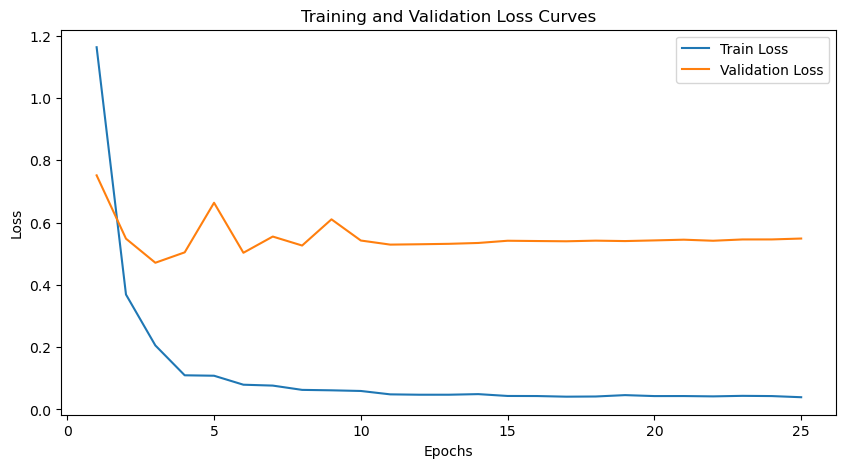

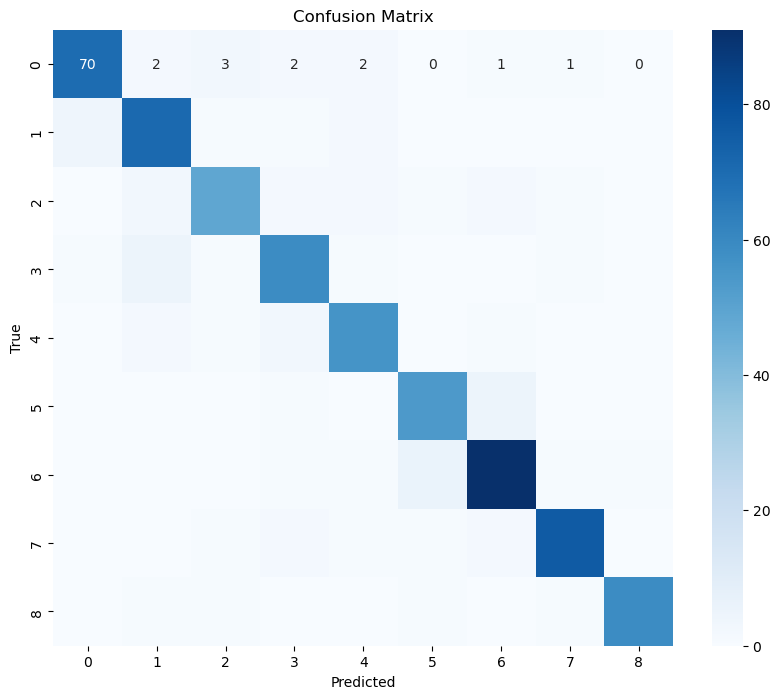

NameError: name 'precision_per_class' is not defined

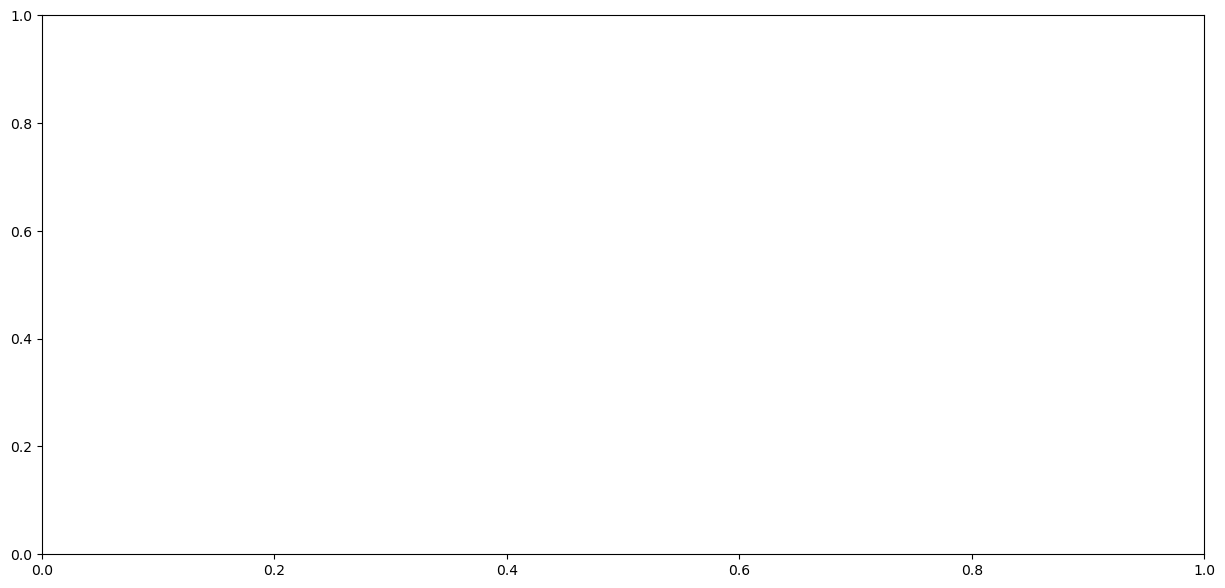

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the DenseNet201 model with updated classifier and unfreezing some layers
class DenseNet201Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201Model, self).__init__()
        self.base_model = models.densenet201(pretrained=True)
        for name, param in self.base_model.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1920, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Instantiate the model
num_classes = 9
model = DenseNet201Model(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Sample training loop
num_epochs = 25

# Collect training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    scheduler.step(avg_val_loss)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate per-class accuracy from confusion matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Calculate precision, recall, and F1 score for each class
precisions = precision_score(true_labels, predictions, average=None)
recalls = recall_score(true_labels, predictions, average=None)
f1_scores = f1_score(true_labels, predictions, average=None)

# x = np.arange(len(class_names))
# width = 0.2  # width of the bars

# fig, ax = plt.subplots(figsize=(15, 7))
# bars1 = ax.bar(x - width*1.5, precision_per_class*100, width, label='Precision')
# bars2 = ax.bar(x - width*0.5, recall_per_class*100, width, label='Recall')
# bars3 = ax.bar(x + width*0.5, f1_per_class*100, width, label='F1 Score')
# bars4 = ax.bar(x + width*1.5, [accuracy*100]*len(class_names), width, label='Accuracy')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel('Yoga Poses')
# ax.set_ylabel('Scores')
# ax.set_title('Test Metrics by Class')
# ax.set_xticks(x)
# ax.set_xticklabels(class_names, rotation=45)
# ax.legend()

# # Annotate bars with their values
# def annotate_bars(bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.2f}',
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# annotate_bars(bars1)
# annotate_bars(bars2)
# annotate_bars(bars3)
# annotate_bars(bars4)

# plt.tight_layout()

# plt.show()


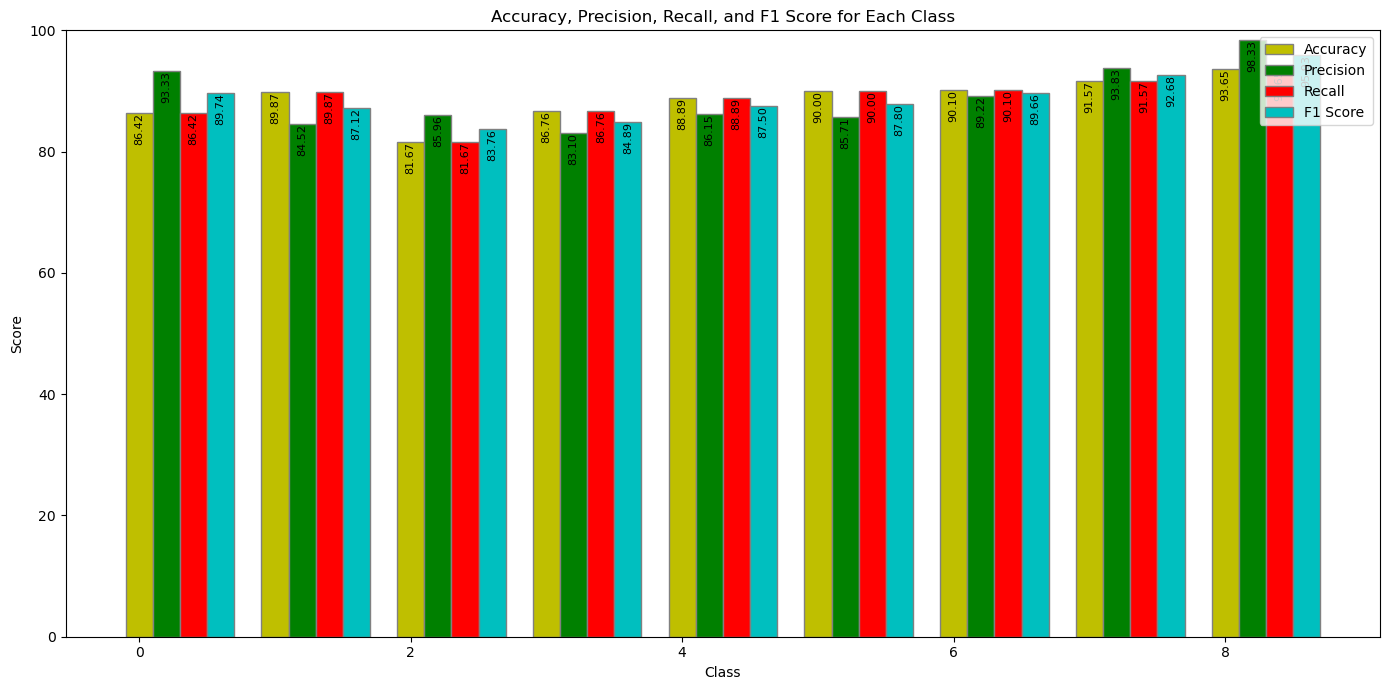

In [21]:
# Plot the combined bar graph for accuracy, precision, recall, and F1 score
bar_width = 0.2
r1 = np.arange(num_classes)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(14, 7))
bars1 = plt.bar(r1, class_accuracies*100, color='y', width=bar_width, edgecolor='grey', label='Accuracy')
bars2 = plt.bar(r2, precisions*100, color='g', width=bar_width, edgecolor='grey', label='Precision')
bars3 = plt.bar(r3, recalls*100, color='r', width=bar_width, edgecolor='grey', label='Recall')
bars4 = plt.bar(r4, f1_scores*100, color='c', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding the values on top of the bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='top', fontsize=8, rotation=90)

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Accuracy, Precision, Recall, and F1 Score for Each Class')

ax.set_xticklabels(class_names, rotation=45)

# plt.xticks([r + 1.5 * bar_width for r in range(num_classes)], range(num_classes))
plt.ylim(0, 100)  # Scores range from 0 to 1
plt.legend()
plt.tight_layout()
plt.savefig('mohan_bargraph.png', dpi=300)
plt.show()

In [1]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in Percentage)')
plt.show()

# Combine metrics into a single bar graph
x = np.arange(len(class_names))
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(15, 7))
bars1 = plt.bar(r1, class_accuracies*100, color='y', width=bar_width, edgecolor='grey', label='Accuracy')
bars2 = plt.bar(r2, precisions*100, color='g', width=bar_width, edgecolor='grey', label='Precision')
bars3 = plt.bar(r3, recalls*100, color='r', width=bar_width, edgecolor='grey', label='Recall')
bars4 = plt.bar(r4, f1_scores*100, color='c', width=bar_width, edgecolor='grey', label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Yoga Poses')
ax.set_ylabel('Scores')
ax.set_title('Test Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

# Annotate bars with their values
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='top', fontsize=8, rotation=90)

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.tight_layout()
plt.savefig('mohan_bargraph.png', dpi=300)
plt.show()

NameError: name 'plt' is not defined

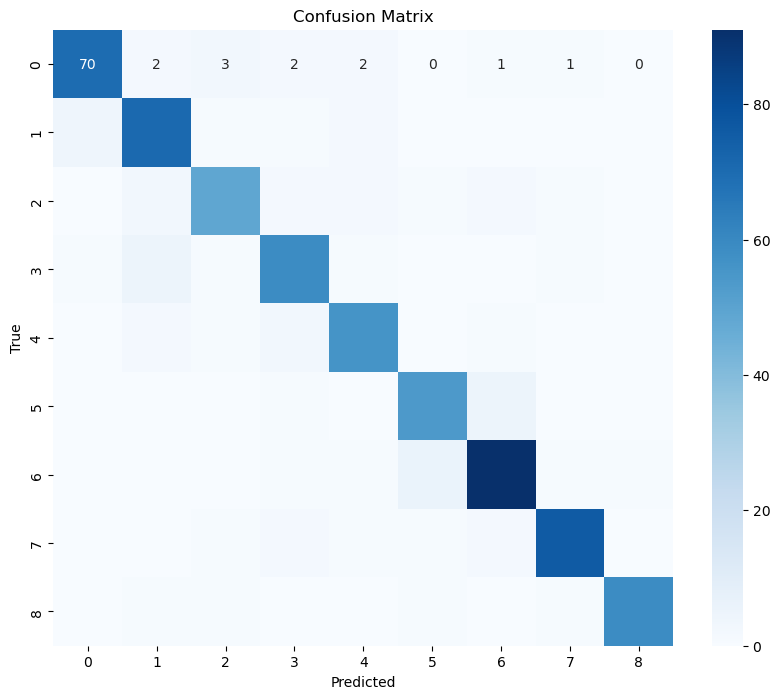

In [10]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# # Define the DenseNet201 model
# class DenseNet201Model(nn.Module):
#     def __init__(self, num_classes):
#         super(DenseNet201Model, self).__init__()
#         # Load the pre-trained DenseNet201 model
#         self.base_model = models.densenet201(pretrained=True)
#         # Freeze the layers
#         for param in self.base_model.parameters():
#             param.requires_grad = False
#         # Modify the classifier
#         self.base_model.classifier = nn.Sequential(
#             nn.Linear(1920, 512),  # Adjust input size based on DenseNet201 architecture
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(512, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # Forward pass through the base model
#         x = self.base_model(x)
#         return x

# # Instantiate the model
# num_classes = 9  # Change this based on your task
# model = DenseNet201Model(num_classes)

# # Print the model architecture
# print(model)

E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet201Model(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import precision_score, recall_score, f1_score
# import torchvision.models as models

# criterion = nn.CrossEntropyLoss()  # Assuming you're using CrossEntropyLoss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Sample training loop
# num_epochs = 30  # Define number of epochs
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     for inputs, labels in train_dataloader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Evaluation phase
#     model.eval()
#     correct = 0
#     total = 0
#     predictions = []
#     true_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             predictions.extend(predicted.tolist())
#             true_labels.extend(labels.tolist())

#     accuracy = correct / total
#     precision = precision_score(true_labels, predictions, average='macro')
#     recall = recall_score(true_labels, predictions, average='macro')
#     f1 = f1_score(true_labels, predictions, average='macro')

#     print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Accuracy: 0.513677811550152, Precision: 0.602366727128443, Recall: 0.4673893095213978, F1 Score: 0.4327508320274637


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [2/30], Accuracy: 0.6413373860182371, Precision: 0.7435653141478169, Recall: 0.6153804608774732, F1 Score: 0.6164014356832515


E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/30], Accuracy: 0.668693009118541, Precision: 0.754434091916443, Recall: 0.6430875323544604, F1 Score: 0.6481394706588081


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [4/30], Accuracy: 0.7750759878419453, Precision: 0.7907498297499487, Recall: 0.7644958080706035, F1 Score: 0.7711198945130988


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [5/30], Accuracy: 0.7750759878419453, Precision: 0.7872283773296207, Recall: 0.76348409686295, F1 Score: 0.7682477023837728


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [6/30], Accuracy: 0.7689969604863222, Precision: 0.8102534474009535, Recall: 0.751230483916037, F1 Score: 0.7602297387206194


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [7/30], Accuracy: 0.7872340425531915, Precision: 0.8084826938992936, Recall: 0.7755260548661336, F1 Score: 0.7806522395837389


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [8/30], Accuracy: 0.7735562310030395, Precision: 0.7975171658142834, Recall: 0.7582517295330253, F1 Score: 0.765295316993723


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [9/30], Accuracy: 0.7644376899696048, Precision: 0.8033195235528394, Recall: 0.7477695118657411, F1 Score: 0.7515908697723841


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [10/30], Accuracy: 0.8024316109422492, Precision: 0.8108840116048222, Recall: 0.7957224600053214, F1 Score: 0.8005193586278427


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [11/30], Accuracy: 0.8054711246200608, Precision: 0.811675244427831, Recall: 0.8025636180929588, F1 Score: 0.8028663915537605


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [12/30], Accuracy: 0.8161094224924013, Precision: 0.8216435209522005, Recall: 0.8067128879151491, F1 Score: 0.8112092428252085


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [13/30], Accuracy: 0.8145896656534954, Precision: 0.815774749981624, Recall: 0.8107129487025021, F1 Score: 0.8121946725781365


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [14/30], Accuracy: 0.8191489361702128, Precision: 0.8285785681465836, Recall: 0.8112584554604279, F1 Score: 0.8166870764497847


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [15/30], Accuracy: 0.8221884498480243, Precision: 0.8228182733511278, Recall: 0.8171080226821792, F1 Score: 0.8186520009278984


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [16/30], Accuracy: 0.8161094224924013, Precision: 0.8226563832852645, Recall: 0.811795749088094, F1 Score: 0.8131768976418781


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Epoch [17/30], Accuracy: 0.8206686930091185, Precision: 0.8260624984257086, Recall: 0.8142698217845042, F1 Score: 0.8174638175638128


E:\Anaconda\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [21]:
import torch
# Assuming `model` is your PyTorch model
torch.save(model.state_dict(), 'model3_densenet2.pth')

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

# Assuming the models were saved as state dictionaries, not entire model objects
m1_state_dict = torch.load('model_ViT2.pth')

m2_state_dict = torch.load('model3_resnet2.pth')
m3_state_dict = torch.load('model3_densenet2.pth')

# Define the models architecture
m1 = to_device(pretrained_vit,device)# Example for ViT, you should use the actual model instantiation function
num_classes = 9  # Change this based on your task

m2= to_device(ResNet50Model(num_classes),device)
 # Example for ResNet, adjust according to your actual model
m3 =to_device(DenseNet201Model(num_classes),device) # Example for DenseNet, adjust accordingly

# Load the state dicts into the models
m1.load_state_dict(m1_state_dict)
m2.load_state_dict(m2_state_dict)
m3.load_state_dict(m3_state_dict)

# # Define the ensemble model architecture
# class EnsembleModel(nn.Module):
#     def __init__(self, models):
#         super(EnsembleModel, self).__init__()
#         self.models = nn.ModuleList(models)
#         self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)  # Average pooling layer

#     def forward(self, x):
#         model_outputs = [model(x) for model in self.models]
#         avg_output = torch.mean(torch.stack(model_outputs), dim=0)
#         return self.avg_pool(avg_output)

# # Assuming you want to convert the input shape to match PyTorch conventions (channels first)
# input_shape = (3, 224, 224)  # Assuming input shape is (channels, height, width)

# # Create an instance of the ensemble model
# ensemble_model = EnsembleModel([m1, m2, m3])

# # Convert the input shape to PyTorch conventions (channels first)
# model_input = torch.randn(1, *input_shape)

# # Perform a forward pass to compute the ensemble output
# ensemble_output = ensemble_model(model_input)

# # Print the shape of the ensemble output (optional)
# print("Shape of ensemble output:", ensemble_output.shape)


<All keys matched successfully>

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models



# Define the ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, m1, m2, m3):
        super(EnsembleModel, self).__init__()
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to get a fixed-size output

    def forward(self, x):
        x1 = self.m1(x.clone())  # Clone the input tensor to avoid in-place modifications
        x2 = self.m2(x.clone())
        x3 = self.m3(x.clone())
        # Perform averaging or any other fusion technique
        x = (x1 + x2 + x3) / 3
        return x

# Initialize ensemble model
ensemble_model = EnsembleModel(m1, m2, m3)

# Print ensemble model summary
print(ensemble_model)


EnsembleModel(
  (m1): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Laye

In [27]:
# Check the keys in the saved state dictionary
print("Keys in the saved state dictionary:")
print(list(m2_state_dict.keys()))

# Check the keys in the instantiated ViT model
print("\nKeys in the instantiated ViT model:")
print(list(m2.state_dict().keys()))

Keys in the saved state dictionary:
['base_model.conv1.weight', 'base_model.bn1.weight', 'base_model.bn1.bias', 'base_model.bn1.running_mean', 'base_model.bn1.running_var', 'base_model.bn1.num_batches_tracked', 'base_model.layer1.0.conv1.weight', 'base_model.layer1.0.bn1.weight', 'base_model.layer1.0.bn1.bias', 'base_model.layer1.0.bn1.running_mean', 'base_model.layer1.0.bn1.running_var', 'base_model.layer1.0.bn1.num_batches_tracked', 'base_model.layer1.0.conv2.weight', 'base_model.layer1.0.bn2.weight', 'base_model.layer1.0.bn2.bias', 'base_model.layer1.0.bn2.running_mean', 'base_model.layer1.0.bn2.running_var', 'base_model.layer1.0.bn2.num_batches_tracked', 'base_model.layer1.0.conv3.weight', 'base_model.layer1.0.bn3.weight', 'base_model.layer1.0.bn3.bias', 'base_model.layer1.0.bn3.running_mean', 'base_model.layer1.0.bn3.running_var', 'base_model.layer1.0.bn3.num_batches_tracked', 'base_model.layer1.0.downsample.0.weight', 'base_model.layer1.0.downsample.1.weight', 'base_model.layer1.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have defined your ensemble model, train_loader, and test_loader

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the ensemble model to the appropriate device
ensemble_model = ensemble_model.to(device)

# Define optimizer
optimizer = optim.Adam(ensemble_model.parameters())

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define number of epochs
epochs = 20

# Training loop
for epoch in range(epochs):
    ensemble_model.train()  # Set the model to train mode
    
    for inputs, targets in train_dataloader:
        # Move inputs and targets to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = ensemble_model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
    
    # Validation loop
    ensemble_model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = ensemble_model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            # Calculate true positives, predicted positives, and actual positives
            true_positives += ((predicted == 1) & (targets == 1)).sum().item()
            predicted_positives += (predicted == 1).sum().item()
            actual_positives += (targets == 1).sum().item()

    # Calculate precision, recall, and F1-score
    precision = true_positives / predicted_positives if predicted_positives != 0 else 0
    recall = true_positives / actual_positives if actual_positives != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calculate validation accuracy
    val_accuracy = val_correct / val_total

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)
    print(f"Validation Accuracy: {val_accuracy:.4f}")


E:\Anaconda\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
E:\Anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Precision: 0.8414634146341463
Recall: 0.8734177215189873
F1-score: 0.857142857142857
Validation Accuracy: 0.8389
Precision: 0.7717391304347826
Recall: 0.8987341772151899
F1-score: 0.8304093567251462
Validation Accuracy: 0.8435
Precision: 0.875
Recall: 0.8860759493670886
F1-score: 0.8805031446540881
Validation Accuracy: 0.8602
Precision: 0.875
Recall: 0.8860759493670886
F1-score: 0.8805031446540881
Validation Accuracy: 0.8541
Precision: 0.875
Recall: 0.8860759493670886
F1-score: 0.8805031446540881
Validation Accuracy: 0.8708
Precision: 0.8111111111111111
Recall: 0.9240506329113924
F1-score: 0.8639053254437871
Validation Accuracy: 0.8663
Precision: 0.8607594936708861
Recall: 0.8607594936708861
F1-score: 0.8607594936708861
Validation Accuracy: 0.8632
Precision: 0.8352941176470589
Recall: 0.8987341772151899
F1-score: 0.8658536585365854
Validation Accuracy: 0.8632
Precision: 0.8846153846153846
Recall: 0.8734177215189873
F1-score: 0.8789808917197452
Validation Accuracy: 0.8663
Precision: 0.8

In [33]:
import torch
import torch.nn as nn

class WeightedAverageLayer(nn.Module):
    def __init__(self, w1, w2, w3):
        super(WeightedAverageLayer, self).__init__()
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def forward(self, outputs):
        # Perform weighted average computation
        ensemble_output = self.w1 * outputs[0] + self.w2 * outputs[1] + self.w3 * outputs[2]
        return ensemble_output


In [34]:
import torch.nn as nn

# Define the weighted average layer
class WeightedAverageLayer(nn.Module):
    def __init__(self, w1, w2, w3):
        super(WeightedAverageLayer, self).__init__()
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def forward(self, outputs):
        weighted_sum = self.w1 * outputs[0] + self.w2 * outputs[1] + self.w3 * outputs[2]
        return weighted_sum

# Assuming 'outputs' is a list containing outputs from individual models

# Create an instance of the weighted average layer
w1, w2, w3 = 0.3, 0.1, 0.6
weighted_avg_layer = WeightedAverageLayer(w1, w2, w3)

# Define ensemble model and weighted average layer
num_classes = 9

class EnsembleModel(nn.Module):
    def __init__(self, m1, m2, m3, weighted_avg_layer):
        super(EnsembleModel, self).__init__()
        self.model1 = m1
        self.model2 = m2
        self.model3 = m3
        self.weighted_avg_layer = weighted_avg_layer

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        output3 = self.model3(x)
        ensemble_output = self.weighted_avg_layer([output1, output2, output3])
        return ensemble_output

# Define ensemble model
ensemble_model = EnsembleModel(pretrained_vit, ResNet50Model(num_classes), DenseNet201Model(num_classes), weighted_avg_layer)

# Check if model has trainable parameters
if list(ensemble_model.parameters()):
    # If there are trainable parameters, define optimizer and loss function
    optimizer = optim.Adam(ensemble_model.parameters())
    criterion = nn.CrossEntropyLoss()
else:
    # If there are no trainable parameters, handle the case appropriately
    print("No trainable parameters found in the model.")

print(ensemble_model)

EnsembleModel(
  (model1): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the ensemble model to the same device
ensemble_model.to(device)
num_epochs=20
# Training loop
for epoch in range(num_epochs):
    ensemble_model.train()  # Set the model to train mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the same device as the model
        optimizer.zero_grad()  # Zero the gradients
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.4f}")
    
    # Validation loop
    ensemble_model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the same device as the model
            outputs = ensemble_model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    
    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/20], Loss: 0.1206, Accuracy: 0.9671
Validation Accuracy: 0.8526
Epoch [2/20], Loss: 0.1006, Accuracy: 0.9737
Validation Accuracy: 0.8465
Epoch [3/20], Loss: 0.0994, Accuracy: 0.9724
Validation Accuracy: 0.8632
Epoch [4/20], Loss: 0.0926, Accuracy: 0.9743
Validation Accuracy: 0.8602
Epoch [5/20], Loss: 0.0825, Accuracy: 0.9750
Validation Accuracy: 0.8617
Epoch [6/20], Loss: 0.0993, Accuracy: 0.9697
Validation Accuracy: 0.8617
Epoch [7/20], Loss: 0.0832, Accuracy: 0.9750
Validation Accuracy: 0.8541
Epoch [8/20], Loss: 0.0948, Accuracy: 0.9724
Validation Accuracy: 0.8632
Epoch [9/20], Loss: 0.0818, Accuracy: 0.9776
Validation Accuracy: 0.8632
Epoch [10/20], Loss: 0.0789, Accuracy: 0.9756
Validation Accuracy: 0.8571
Epoch [11/20], Loss: 0.0845, Accuracy: 0.9730
Validation Accuracy: 0.8632
Epoch [12/20], Loss: 0.0769, Accuracy: 0.9763
Validation Accuracy: 0.8663
Epoch [13/20], Loss: 0.0871, Accuracy: 0.9750
Validation Accuracy: 0.8663
Epoch [14/20], Loss: 0.0832, Accuracy: 0.9737
V